In [2]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import sklearn
import pysindy as ps
from tools import plot_main, plot_clustered_kuramoto

# 数据生成

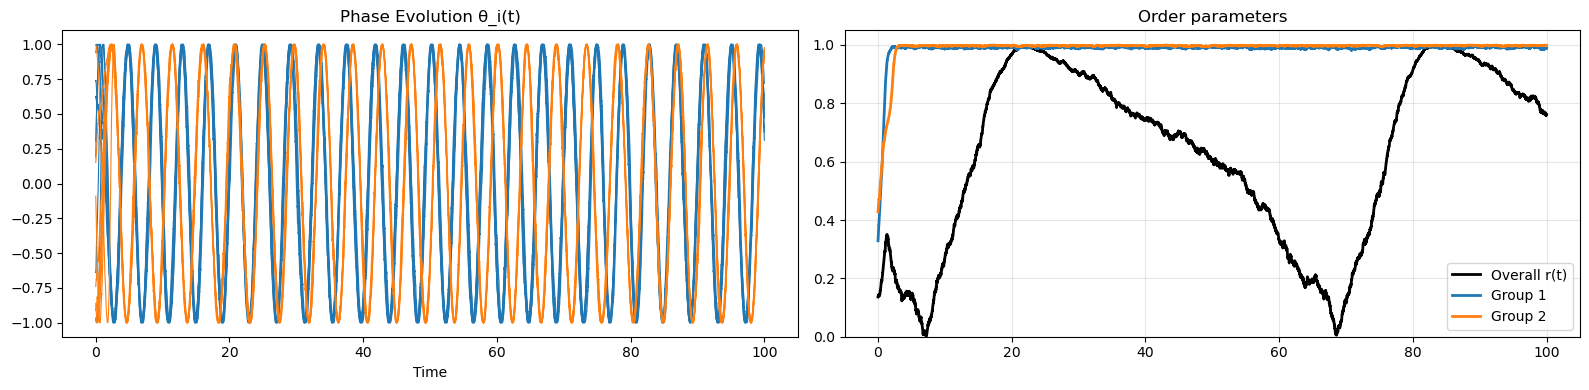

In [3]:
N=16
X_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=5,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=100,
    random_state=0
)


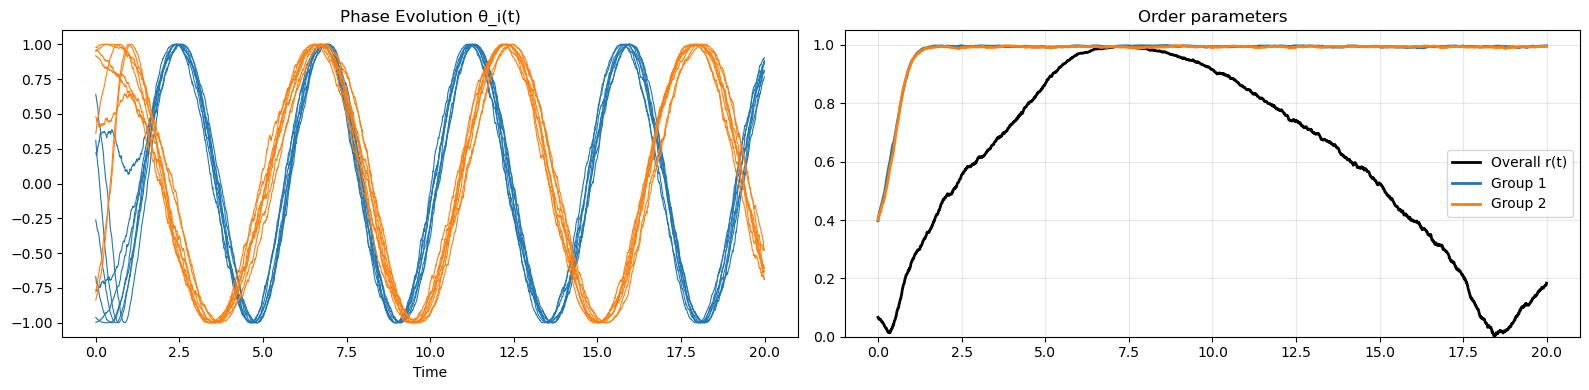

In [4]:
X_test, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=5,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=20,
    random_state=42
)

# SINDy

In [15]:
dt=0.01
sr3_optimizer = ps.SR3(reg_weight_lam=0.1, regularizer="l1")
fourier_library = ps.FourierLibrary(n_frequencies=1)
model = ps.SINDy(feature_library=fourier_library, optimizer=sr3_optimizer, discrete_time=True)
model.fit(X_train, t=dt)
model.print()

(x0)[k+1] = 0.890 sin(1 x0[k]) + 0.033 sin(1 x5[k]) + -0.029 sin(1 x17[k]) + 0.126 sin(1 x19[k]) + 0.078 sin(1 x20[k]) + -0.132 sin(1 x21[k]) + -0.130 sin(1 x23[k])
(x1)[k+1] = 0.899 sin(1 x1[k]) + 0.043 sin(1 x16[k]) + -0.024 sin(1 x17[k]) + 0.165 sin(1 x19[k]) + 0.073 sin(1 x20[k]) + -0.151 sin(1 x21[k]) + -0.079 sin(1 x23[k])
(x2)[k+1] = 0.994 sin(1 x2[k]) + 0.017 sin(1 x16[k]) + -0.017 sin(1 x17[k]) + 0.172 sin(1 x19[k]) + 0.076 sin(1 x20[k]) + -0.141 sin(1 x21[k]) + -0.105 sin(1 x23[k])
(x3)[k+1] = 0.859 sin(1 x3[k]) + 0.103 sin(1 x5[k]) + -0.035 sin(1 x17[k]) + 0.081 sin(1 x19[k]) + 0.084 sin(1 x20[k]) + -0.119 sin(1 x21[k]) + -0.111 sin(1 x23[k])
(x4)[k+1] = 0.880 sin(1 x4[k]) + 0.055 sin(1 x5[k]) + -0.049 sin(1 x17[k]) + 0.139 sin(1 x19[k]) + 0.057 sin(1 x20[k]) + -0.115 sin(1 x21[k]) + -0.120 sin(1 x23[k])
(x5)[k+1] = 0.042 sin(1 x3[k]) + 0.781 sin(1 x5[k]) + -0.012 sin(1 x7[k]) + 0.002 sin(1 x16[k]) + 0.129 sin(1 x19[k]) + 0.056 sin(1 x20[k]) + -0.122 sin(1 x21[k]) + -0.006 s

In [16]:
model.score(X_train, t=dt)

0.9689016816564068

In [17]:
model.score(X_test, t=dt)

0.9500844302434058

(32, 64)


<Axes: >

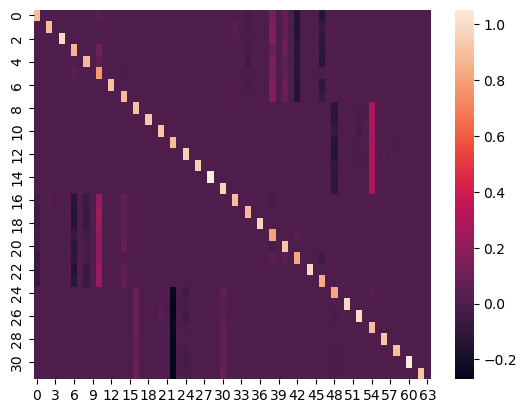

In [20]:
A = model.coefficients()
print(A.shape)
sns.heatmap(model.coefficients())

# 预测

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_95691/3499515223.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


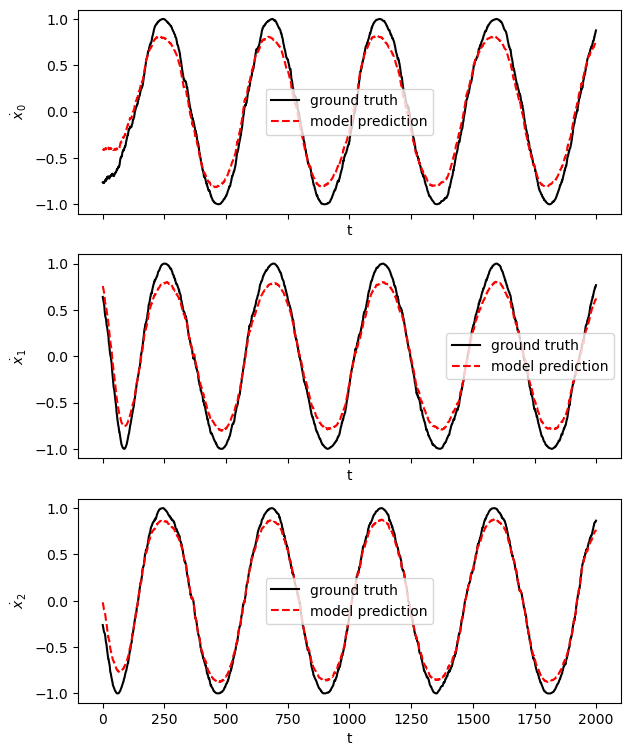

In [18]:
X_test_predicted = model.predict(X_test)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(X_test[:, i], "k", label="ground truth")
    axs[i].plot(X_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
fig.show()

enter simulate
True


/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_95691/2696135264.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


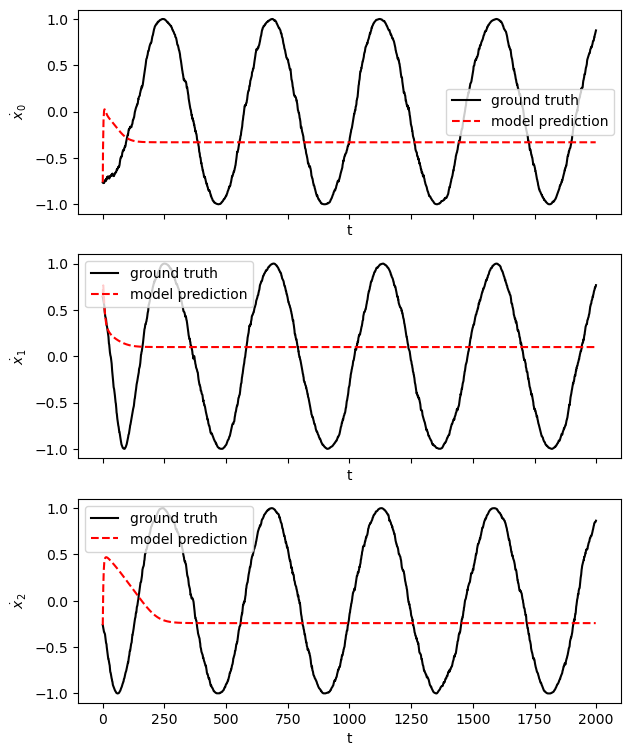

In [19]:
init_data = X_test[0,:]
X_test_predicted = model.simulate(init_data,len(X_test)-1)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(X_test[:, i], "k", label="ground truth")
    axs[i].plot(X_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
fig.show()

# 矩阵稀疏性

In [21]:
def matrix_l1_norm_manual(matrix):
    """
    手动计算矩阵的L1范数（不使用numpy）
    """
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 计算每列的绝对值之和
    column_sums = []
    for j in range(cols):
        col_sum = 0
        for i in range(rows):
            col_sum += abs(matrix[i][j])
        column_sums.append(col_sum)
    
    # 返回最大的列和
    return max(column_sums)

matrix_l1_norm_manual(A.T)

np.float64(1.569614004386764)

In [22]:
import numpy as np

def matrix_l0_norm_corrected(matrix, threshold=1e-10):
    """
    计算矩阵的L0范数（各列非零元素数量的最大值）
    
    参数:
    matrix: numpy数组或可以转换为numpy数组的矩阵
    threshold: 阈值，绝对值小于此值的元素视为零
    
    返回:
    l0_norm: 矩阵的L0范数（整数）
    column_norms: 各列的L0范数
    """
    matrix = np.array(matrix, dtype=float)
    
    # 应用阈值：将接近零的元素视为零
    matrix_thresholded = np.where(np.abs(matrix) < threshold, 0, matrix)
    
    # 计算每列的非零元素数量
    column_norms = []
    for col in range(matrix_thresholded.shape[1]):
        non_zero_count = np.count_nonzero(matrix_thresholded[:, col])
        column_norms.append(non_zero_count)
    
    # 矩阵的L0范数是各列L0范数的最大值
    l0_norm = max(column_norms)
    
    return l0_norm

matrix_l0_norm_corrected(A.T,0.05)

6

# 特征谱与SVD分析

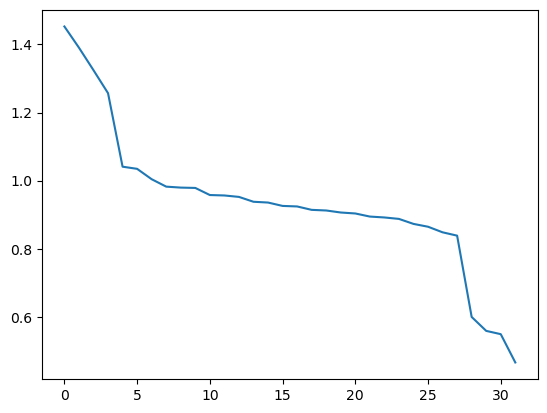

In [24]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.show()

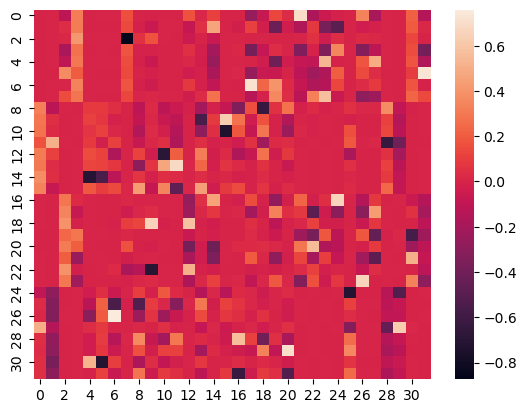

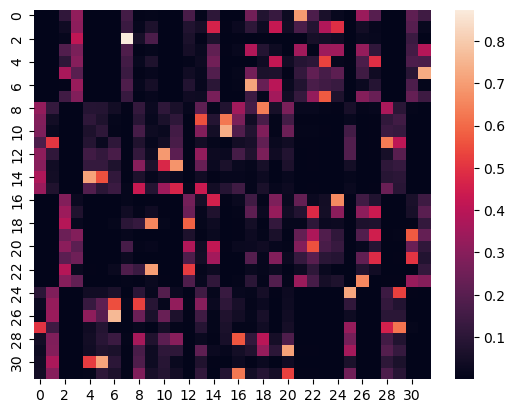

In [25]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

(48, 48)


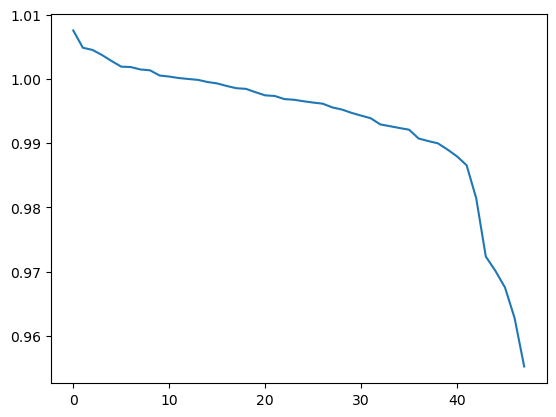

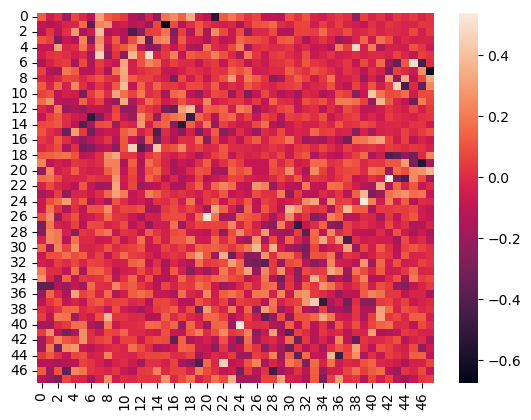

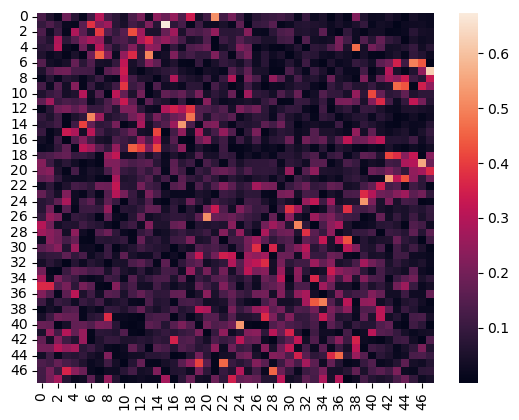

In [434]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()